Comment savoir si notre modèle regarde la bonne chose ? Dans ce notebook, nous verrons une approche pour identifier si le CNN travaille correctement avec les caractéristiques qui sont importantes pour la classification ou la reconnaissance.

La méthode Grad-CAM :

Une façon de s’en assurer est de visualiser ce que les CNN regardent réellement, en utilisant la méthode du Grad-CAM.

La carte d’activation de classe pondérée par le gradient (Grad-CAM) produit une carte thermique qui met en évidence les régions importantes d’une image en utilisant les gradients de la cible (chien, chat) de la couche convolutive finale. 

La méthode Grad-CAM est une technique populaire de visualisation qui est utile pour comprendre comment un réseau neuronal convolutif a été conduit à prendre une décision de classification. Elle est spécifique à chaque classe, ce qui signifie qu’elle peut produire une visualisation distincte pour chaque classe présente dans l’image.

En cas d’erreur de classification, cette méthode peut s’avérer être très utile afin de comprendre où se trouve le problème dans le réseau convolutif. Cela permet aussi d’être plus transparent sur l’algorithme.

Comment ça marche ?

Grad-CAM consiste à chercher quelles parties de l’image ont conduit un réseau neuronal convolutif à sa décision finale. Cette méthode consiste à produire des cartes thermiques représentant les classes d’activation sur les images reçues en entrée. Une classe d’activation est associée à une classe de sortie spécifique.

Ces classes vont permettre d’indiquer l’importance de chaque pixel par rapport à la classe concernée en augmentant ou diminuant l’intensité du pixel.

Par exemple, si une image est utilisée dans un réseau convolutif de chiens et de chats, la visualisation de Grad-CAM permet de générer une heatmap (carte thermique) pour la classe “chat”, indiquant dans quelle mesure les différentes parties de l’image correspondent à un chat, et également une carte thermique pour la classe “chien”, indiquant dans quelle mesure les parties de l’image correspondent à un chien.

Par exemple, considérons un CNN de chiens et de chats. La méthode Grad-CAM va permettre de générer une heatmap (carte thermique) pour la classe d’objets chat pour indiquer dans quelle mesure chacune des parties d’une image correspond à un chat et également une heatmap pour la classe d’objet chien en procédant de la même manière.

La carte d’activation de classe attribue une importance à chaque position (x, y) dans la dernière couche convolutive en calculant la combinaison linéaire des activations, pondérée par les poids de sortie correspondants pour la classe observée (terrier australien dans l’exemple ci-dessous). La cartographie d’activation de classe résultante est ensuite rééchantillonnée à la taille de l’image d’entrée. Ceci est illustré par la carte thermique (une heatmap) ci-dessous.

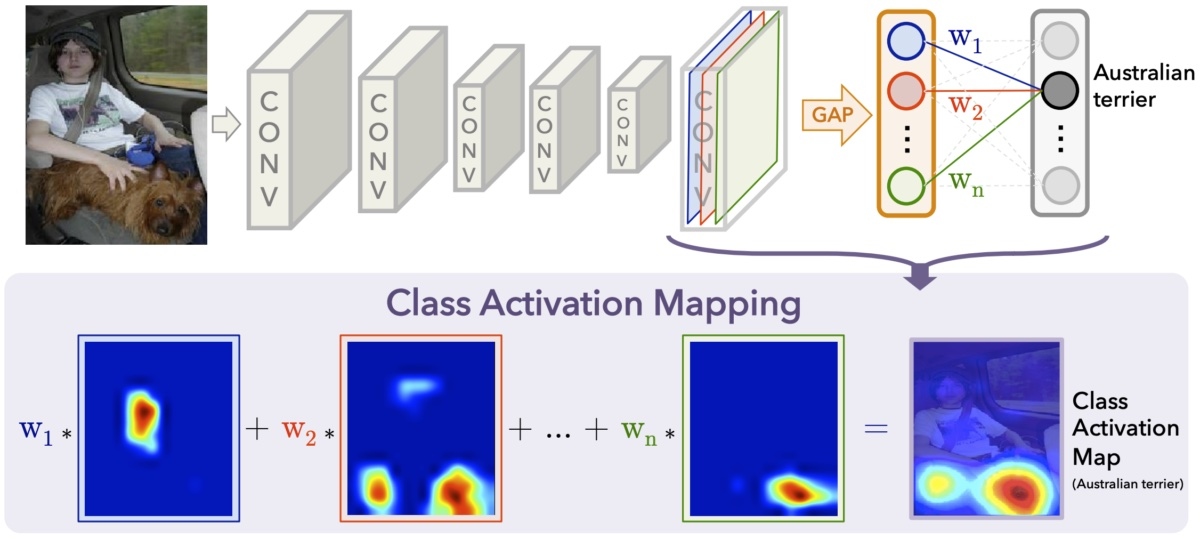Carte Thermique

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import h5py

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

def create_model(input_shape, n_classes, optimizer, fine_tune=0):

    conv_base = InceptionV3(classes=n_classes, weights=None, input_shape=input_shape, classifier_activation="softmax")

    conv_base.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    return conv_base

In [4]:
input_shape = (299, 299, 1)
from tensorflow.keras.optimizers import Adam
optim_1 = Adam(learning_rate=0.000161803398875)
n_classes=3


# First we'll train the model without Fine-tuning
model_builder = create_model(input_shape, n_classes, optim_1, fine_tune=0)
model_builder.build(input_shape)
model_builder.load_weights('InceptionV3.h5')

In [5]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "mixed10"

L'algorithme Grad-CAM

In [6]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size, grayscale=True)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [7]:
img_path = r"C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\val\PNEUMONIA_BACTERIA\person1951_bacteria_4882.jpeg"

Testons-le

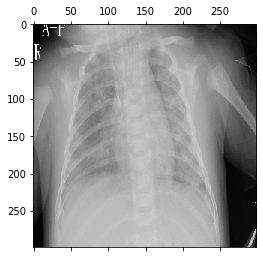

La classe prédite est : PNEUMONIA BACTERIA


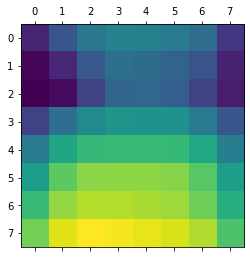

In [11]:
from tensorflow.keras.preprocessing import image

img_size = (299,299)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# # img = image.load_img(ORIGINAL, target_size=(DIM, DIM))
# img = tf.keras.utils.load_img(ORIGINAL, color_mode="grayscale", target_size=(DIM, DIM))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(img, (299,299))

plt.matshow(img, cmap=plt.cm.gray)
plt.show()

# Prédiction d'images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = np.argmax(model.predict(images, batch_size=10), axis=-1)
classe_name = ""
if classes[0] == 0:
    classe_name = "NORMAL"
if classes[0] == 1:
    classe_name = "PNEUMONIA BACTERIA"
if classes[0] == 2:
    classe_name = "PNEUMONIA VIRUS"
print("La classe prédite est :",classe_name)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Créer une visualisation superposée

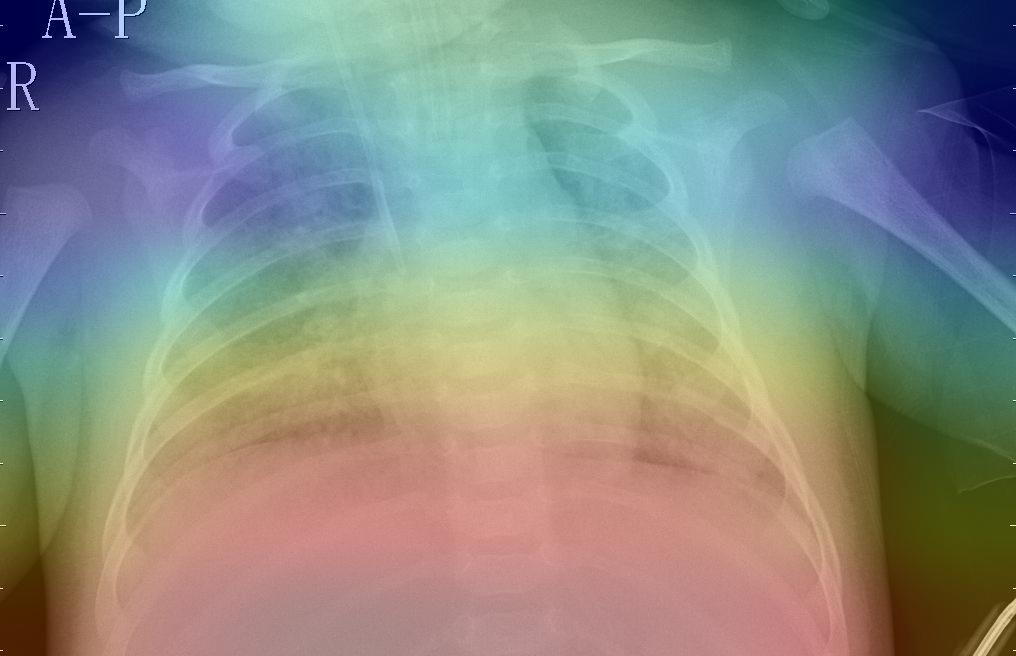

In [9]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

Dans ce notebook, nous avons vu une nouvelle technique pour interpréter les réseaux neuronaux convolutifs qui sont une architecture de pointe, en particulier pour les tâches liées à l’image. La recherche dans le domaine de l’apprentissage automatique interprétable progresse à un rythme accéléré et s’avère très importante pour gagner la confiance des utilisateurs et contribuer à l’amélioration des modèles.